# Import Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt

# Import data 

In [3]:
orders=pd.read_csv('orders.csv',encoding= 'unicode_escape')

In [5]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/2011,CA-2011-100006,Dennis Kane,378
1,7/8/2011,CA-2011-100090,Ed Braxton,699
2,3/14/2011,CA-2011-100293,Neil Franz?sisch,91
3,1/29/2011,CA-2011-100328,Jasper Cacioppo,4
4,4/8/2011,CA-2011-100363,Jim Mitchum,21


# EDA 

In [6]:
orders.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   order_date   5009 non-null   object
 1   order_id     5009 non-null   object
 2   customer     5009 non-null   object
 3   grand_total  5009 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 156.7+ KB


In [14]:
NOW = dt.datetime(2014,12,31)

In [7]:
# Make the date_placed column datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [9]:
total_amt_by_customer = orders.groupby(orders['customer']).grand_total.sum()
total_amt_by_customer.head()

customer
Aaron Bergman       887
Aaron Hawkins      1744
Aaron Smayling     3050
Adam Bellavance    7756
Adam Hart          3249
Name: grand_total, dtype: int64

<Figure size 720x576 with 0 Axes>

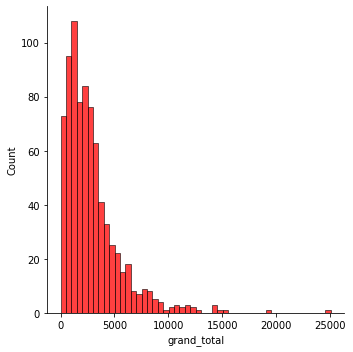

In [10]:
plt.figure(figsize=(10,8))
sns.displot(total_amt_by_customer,color='r',bins=50)

In [11]:
total_amt_by_date = orders.groupby(orders['order_date']).grand_total.sum()
total_amt_by_date

order_date
2011-01-04      16
2011-01-05     288
2011-01-06      20
2011-01-07    4407
2011-01-08      87
              ... 
2014-12-27     815
2014-12-28     178
2014-12-29    1658
2014-12-30    2916
2014-12-31     714
Name: grand_total, Length: 1238, dtype: int64

<Figure size 720x576 with 0 Axes>

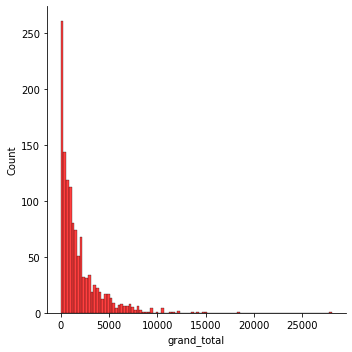

In [12]:
plt.figure(figsize=(10,8))
sns.displot(total_amt_by_date,color='r',bins=100)

# Create RFM table

create RFM table

In [15]:
rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (NOW - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary Value

rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

RFM table

In [45]:
rfmTable.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212


validating RFM table

In [17]:
validation  = orders[orders['customer']=='Yoseph Carroll']
validation

,order_date,order_id,customer,grand_total
236,2011-11-17,CA-2011-119375,Yoseph Carroll,3116
1497,2012-11-12,CA-2012-153220,Yoseph Carroll,16
1857,2013-04-08,CA-2013-110499,Yoseph Carroll,1200
2067,2013-09-07,CA-2013-123932,Yoseph Carroll,372
3233,2014-12-27,CA-2014-121741,Yoseph Carroll,751


In [18]:
(NOW - dt.datetime(2014,12,27)).days==4

True

# Determining RFM Quartiles

In [22]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75]) 

In [23]:
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [24]:
quantiles = quantiles.to_dict()
quantiles

{'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1145.0, 0.5: 2257.0, 0.75: 3784.0},
 'recency': {0.25: 30.0, 0.5: 75.0, 0.75: 183.0}}

# Creating RFM Segmentation 

In [25]:
rfmsegmentation = rfmTable


We create two classes for the RFM segmentation since, being high recency is bad, while high frequency and monetary value is good

In [26]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]: 
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [27]:
rfmsegmentation['R_Quartile'] = rfmsegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmsegmentation['F_Quartile'] = rfmsegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmsegmentation['M_Quartile'] = rfmsegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))


In [28]:
rfmsegmentation['RFMClass'] = rfmsegmentation.R_Quartile.map(str) \
                            + rfmsegmentation.F_Quartile.map(str) \
                            + rfmsegmentation.M_Quartile.map(str)

In [43]:
rfmsegmentation.head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212


In [46]:
rfmsegmentation.to_csv('RFM-Segmentation.csv', sep=',')

In [ ]:
bestcustomers = rfmsegmentation[rfmsegmentation['RFMClass']=='111']
bestcustomers

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Alan Hwang,6,9,4806,1,1,1,111
Annie Thurman,13,10,3831,1,1,1,111
Arianne Irving,13,10,4376,1,1,1,111
Ben Ferrer,16,11,5907,1,1,1,111
Brenda Bowman,28,9,6766,1,1,1,111
Chris Cortes,20,12,3913,1,1,1,111
Dan Reichenbach,3,9,6528,1,1,1,111
Dean Katz,10,9,4801,1,1,1,111
Emily Phan,12,17,5479,1,1,1,111


In [ ]:
bestcustomers.sort_values('monetary_value',ascending=False).head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Sanjit Engle,9,11,12210,1,1,1,111
John Lee,21,11,9801,1,1,1,111
Pete Kriz,9,12,8647,1,1,1,111
Harry Marie,2,10,8237,1,1,1,111
Lena Creighton,16,12,7661,1,1,1,111


# Segmented Characteristics 

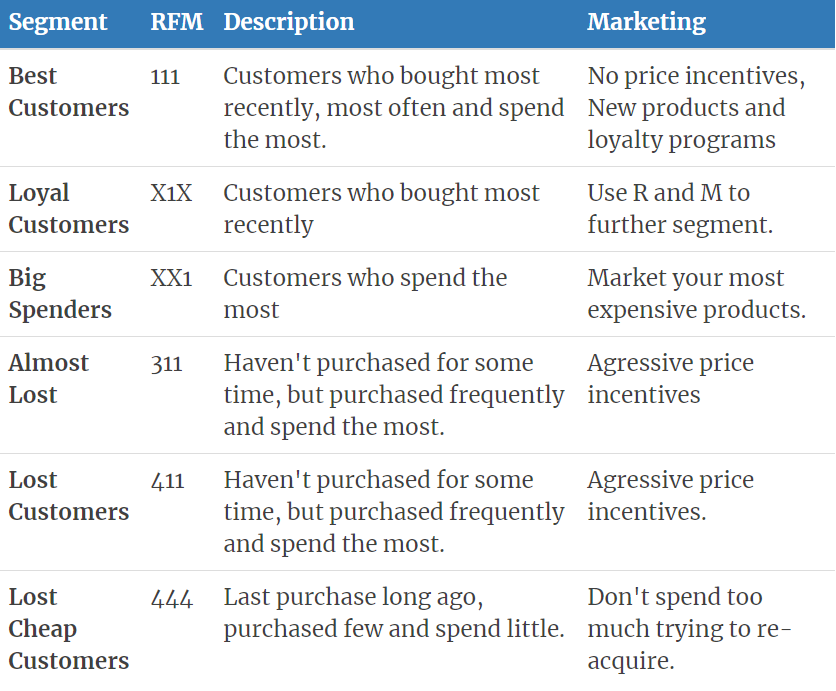